# Init

In [1]:
ON_COLAB = True
if ON_COLAB:
    import os
    os.chdir('/content/')
    !pip install -q datasets accelerate torchvision youtube_dl evaluate
    !git clone https://github.com/linv24/multimodal-commonsense.git
    os.chdir('/content/multimodal-commonsense/dev/scripts')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00
Cloning into 'multimodal-commonsense'...
remote: Enumerating objects: 2995, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 2995 (delta 50), reused 36 (delta 36), pack-reused 2909
Receiving objects: 100% (2995/2995), 289.85 MiB | 25.03 MiB/s, done.
Resolving deltas: 100% (260/260), done.
Updating files: 100% (1907/1907), done.


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import transformers
from transformers import (AutoTokenizer, FlavaModel, FlavaTextModel, BertTokenizer,
                          FlavaProcessor, AutoModelForMultipleChoice, Trainer,
                          TrainingArguments, RobertaModel, RobertaConfig,
                          FlavaTextConfig, FlavaConfig, CLIPModel, CLIPTextModel,
                          CLIPTokenizer, CLIPProcessor, CLIPTextConfig)
from transformers.modeling_outputs import MultipleChoiceModelOutput
from datasets import Dataset, load_dataset
import torchvision
from torchvision.io import read_image
import pandas as pd
import json
import evaluate
import numpy as np
import requests
import re

import data_util

# Testing

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
s1 = 'i have cake and i am hungry, so'
s2 = 'i will eat a slice of cake'

tokens = tokenizer(s1, s2)
tokens

{'input_ids': [101, 1045, 2031, 9850, 1998, 1045, 2572, 7501, 1010, 2061, 102, 1045, 2097, 4521, 1037, 14704, 1997, 9850, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# default flava model
model = FlavaModel.from_pretrained('facebook/flava-full')
tokenizer = AutoTokenizer.from_pretrained('facebook/flava-full')

config.json:   0%|          | 0.00/8.69k [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `FlavaTextConfig`. The value `text_config["id2label"]` will be overriden.
`multimodal_config_dict` is provided which will be used to initialize `FlavaMultimodalConfig`. The value `multimodal_config["id2label"]` will be overriden.
`image_codebook_config_dict` is provided which will be used to initialize `FlavaImageCodebookConfig`. The value `image_codebook_config["id2label"]` will be overriden.


pytorch_model.bin:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/358 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# how tokenizer combines text and text_pair as lists of strings
tokens = tokenizer(['sent1 part1', 'sent2 part2'], ['sent1 part2', 'sent2 part2'])
tokenizer.decode(tokens['input_ids'][0])

'[CLS] sent1 part1 [SEP] sent1 part2 [SEP]'

In [ ]:
# text only input
text = 'a photo of a dog'
inputs = tokenizer(text=[text], return_tensors='pt', padding='max_length', max_length=77)
text_embedding = model.get_text_features(**inputs)

print(f'{inputs=}')
print(f'{text_embedding=}') # length of max_length

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


inputs={'input_ids': tensor([[ 101, 1037, 6302, 1997, 1037, 3899,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
out = model(**inputs)
out.keys()

odict_keys(['text_embeddings', 'text_output'])

In [ ]:
# multimodal input
processor = FlavaProcessor.from_pretrained("facebook/flava-full")

source_id = '-1IBHYS3L-Y'
text = 'Then, the man writes over the snow covering the window of a car, and a woman wearing winter clothes smiles. then, the man adds wax to the windshield and cuts it.' # first training example context + ending 0
image = read_image(f'../data/hellaswag_images/{source_id}.png') # shape = torch.Size([3, 144, 192])

inputs = processor(
    text=[text],
    images=[image],
    return_tensors='pt',
    padding='max_length',
    max_length=128,
)
print(f'{inputs.keys()=}')

outputs = model(**inputs)
image_embeddings = outputs.image_embeddings # Batch size X (Number of image patches + 1) x Hidden size => 2 X 197 X 768
text_embeddings = outputs.text_embeddings # Batch size X (Text sequence length + 1) X Hidden size => 2 X 77 X 768
multimodal_embeddings = outputs.multimodal_embeddings # Batch size X (Number of image patches + Text Sequence Length + 3) X Hidden size => 2 X 275 x 768

outputs.text_output.keys()

preprocessor_config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

inputs.keys()=dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values'])


odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [ ]:
outputs.keys()

odict_keys(['image_embeddings', 'image_output', 'text_embeddings', 'text_output', 'multimodal_embeddings', 'multimodal_output'])

Image incorporation

In [ ]:
t_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
t_ds = data_util.jsonl2ds('../data/jsonl/sampled_hellaswag_train.jsonl')
# train_ds = train_ds.map(preprocess_data, batched=True,
#                         remove_columns=['ind', 'activity_label', 'ctx_a', 'ctx_b', 'ctx', 'split', 'split_type', 'endings', 'source_id'])
ex = t_ds[0]
ex

{'ind': 28876,
 'activity_label': 'Playing bagpipes',
 'ctx_a': 'A large group of people are seen sitting on a bus.',
 'ctx_b': 'one woman',
 'ctx': 'A large group of people are seen sitting on a bus. one woman',
 'split': 'train',
 'split_type': 'indomain',
 'label': 0,
 'endings': ['stands up and begins walking towards the back.',
  'is interviewed by the driver.',
  'screams while being held down.',
  'leads the group down a road.'],
 'source_id': 'activitynet~v_UhNgPK81rKM',
 '__index_level_0__': 0}

True


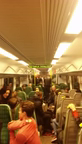

In [ ]:
yt_id = re.search(r'activitynet~v_(.*)', ex['source_id']).group(1)
print(os.path.exists(f'../data/hellaswag_images/hellaswag_train/{yt_id}.png'))
ex_img = Image.open(f'../data/hellaswag_images/hellaswag_train/{yt_id}.png')
ex_img

In [ ]:
print(ex['ctx'] + ' ' + ex['endings'][0])

A large group of people are seen sitting on a bus. one woman stands up and begins walking towards the back.


In [ ]:
ex_text = ex['ctx'] + ' ' + ex['endings'][0]
inps = processor(text=[ex_text], images=[ex_img], return_tensors='pt', padding=True)
inps

{'input_ids': tensor([[49406,   320,  3638,  1771,   539,  1047,   631,  2041,  4919,   525,
           320,  2840,   269,   637,  2308,  6446,   705,   537,  4635,  3941,
          4447,   518,   893,   269, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]]), 'pixel_values': tensor([[[[ 0.5435,  0.5435,  0.5435,  ...,  1.7990,  1.7114,  1.6822],
          [ 0.5435,  0.5435,  0.5289,  ...,  1.6822,  1.5508,  1.4924],
          [ 0.5581,  0.5435,  0.5289,  ...,  1.6238,  1.4924,  1.4340],
          ...,
          [-0.7704, -0.7704, -0.7704,  ...,  0.3099,  0.3099,  0.3099],
          [-0.7996, -0.7996, -0.7996,  ...,  0.1347,  0.1493,  0.1493],
          [-0.8288, -0.8288, -0.8288,  ...,  0.1347,  0.1493,  0.1493]],

         [[-0.1313, -0.1313, -0.1313,  ...,  1.8198,  1.6847,  1.6247],
          [-0.1313, -0.1313, -0.1463,  ...,  1.6997,  1.5196,  1.4596],
          [-0.1163, -0.1163, -0.1463,  ...,  1.5496,  1.38

In [ ]:
out = t_model(**inps)
out.keys()

odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])

# Hyperparams

In [3]:
output_dir = './checkpoint'
logging_dir = './logging'
batch_size = 16
learning_rate = .01
num_epochs = 10

# Text processing

In [4]:
processor = FlavaProcessor.from_pretrained("facebook/flava-full")
tokenizer = AutoTokenizer.from_pretrained('facebook/flava-full')

# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base-uncased')

preprocessor_config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/358 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
# generate encoded ds from jsonl


def preprocess_data(batch): # garbage testing preprocessing
    # each prompt in batch is converted to a list of strings for ctx_a and
    # ctx_b + ending
    # duplicate ctx_a 4 times, one for each ending
    first_sentences = [[ctx_a] * 4 for ctx_a in batch['ctx_a']]
    # print(f'{batch["ctx_a"]=}')
    # print(f'{first_sentences=}')
    # print(f'{len(first_sentences)=}')

    # ctx_b + each ending as a list
    second_sentences = [[f'{ctx_b} {ending}' for ending in batch['endings'][ix]]
                        for ix, ctx_b in enumerate(batch['ctx_b'])]
    # print(f'{batch["ctx_b"]=}')
    # print(f'{second_sentences=}')
    # print(f'{len(second_sentences)=}')

    # flatten contexts and endings
    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    encoding = processor(text=list(zip(first_sentences, second_sentences)),
                         images=None,
                         return_tensors='pt',
                         truncation=True,
                        #  max_length=77,
                         max_length=128,
                         padding='max_length',)
    ret = {k: [v[i : i + 4] for i in range(0, len(v), 4)] for k, v in encoding.items()}
    # if 'label' in batch:
    #     ret['labels'] = batch['label']

    return ret

def preprocess_data_bert(batch): # garbage testing preprocessing
    # each prompt in batch is converted to a list of strings for ctx_a and
    # ctx_b + ending
    # duplicate ctx_a 4 times, one for each ending
    first_sentences = [[ctx_a] * 4 for ctx_a in batch['ctx_a']]
    # print(f'{batch["ctx_a"]=}')
    # print(f'{first_sentences=}')
    # print(f'{len(first_sentences)=}')

    # ctx_b + each ending as a list
    second_sentences = [[f'{ctx_b} {ending}' for ending in batch['endings'][ix]]
                        for ix, ctx_b in enumerate(batch['ctx_b'])]
    # print(f'{batch["ctx_b"]=}')
    # print(f'{second_sentences=}')
    # print(f'{len(second_sentences)=}')

    # flatten contexts and endings
    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    encoding = robertabert_tokenizer(first_sentences,
                              second_sentences,
                         return_tensors='pt',
                         truncation=True,
                         max_length=128,
                         padding='max_length',)
    ret = {k: [v[i : i + 4] for i in range(0, len(v), 4)] for k, v in encoding.items()}
    # if 'label' in batch:
    #     ret['labels'] = batch['label']

    return ret

# ds = data_util.jsonl2ds('../data/jsonl/tiny_hellaswag_train.jsonl')

# encoded_ds = ds.map(preprocess_data, batched=True)
# print(encoded_ds)

# for i in range(2):
#     for j in range(4):
#         print(tokenizer.decode(encoded_ds['input_ids'][i][j]))
#     print(encoded_ds['label'][i])

In [8]:
train_ds = data_util.jsonl2ds('../data/jsonl/sampled_hellaswag_train.jsonl')
train_ds = train_ds.map(preprocess_data, batched=True,
                        remove_columns=['ind', 'activity_label', 'ctx_a', 'ctx_b', 'ctx', 'split', 'split_type', 'endings', 'source_id', '__index_level_0__'])
# train_ds.set_format('pytorch')

split_ds = train_ds.train_test_split(test_size=0.2)
train_ds, val_ds = split_ds['train'], split_ds['test']
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=10)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=10)

test_ds = data_util.jsonl2ds('../data/jsonl/sampled_hellaswag_val.jsonl')
test_ds = test_ds.map(preprocess_data, batched=True,
                      remove_columns=['ind', 'activity_label', 'ctx_a', 'ctx_b', 'ctx', 'split', 'split_type', 'endings', 'source_id'])

print(train_ds)
print(val_ds)
print(test_ds)

Map:   0%|          | 0/1474 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Map:   0%|          | 0/325 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1179
})
Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 295
})
Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 325
})


In [7]:
# t_ds = data_util.jsonl2ds('../data/jsonl/sampled_hellaswag_train.jsonl')
t_df = data_util.jsonl2ds('../data/jsonl/sampled_hellaswag_train.jsonl', return_df=True)
source_id = '-YjGbsbDoxs'
ex = t_df.loc[t_df['source_id'] == f'activitynet~v_{source_id}']
# print(ex)
# print(ex['source_id'])
for j in range(4):
    print(ex['ctx_b'].item() + ' ' + ex['endings'].item()[j])


she then paints about six shades of purple color on the paper.
she makes x patterns across the canvas with the yellow color.
she puts on a cream colored coat and begins painting the white wooden fence without a paint shaker.
she powders the paint in an electric flat brush and applies it over the wall.


# Image processing

In [21]:
def transforms(examples):
    # examples["pixel_values"] = [image.convert("RGB").resize((100,100)) for image in examples["image"]]
    inputs = processor(images=examples['image'], return_tensors='pt', padding=True)
    examples['pixel_values'] = inputs.pixel_values
    return examples

train_img_ds = load_dataset('imagefolder', data_dir='../data/hellaswag_images/hellaswag_train', split='train')
train_img_ds = train_img_ds.map(transforms, batched=True)
train_img_ds

Resolving data files:   0%|          | 0/1155 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1155 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'pixel_values'],
    num_rows: 1155
})

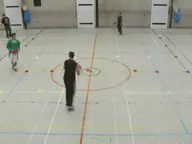

In [22]:
train_img_ds[0]['image']

In [23]:
inps = processor(images=image, return_tensors="pt", padding=True)
inps.pixel_values.shape

NameError: ignored

In [ ]:
# # from testing section
# image = read_image(f'../data/hellaswag_images/{source_id}.png') # shape = torch.Size([3, 144, 192])

# inputs = processor(
#     text=[text],
#     images=[image],
#     return_tensors='pt',
#     padding='max_length',
#     max_length=128,
# )

# Trainer

In [9]:
training_args = TrainingArguments(
    output_dir=output_dir,
    logging_dir=logging_dir,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    optim="adamw_torch",
)

In [14]:
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    print(f'{predictions=}')
    print(f'{labels=}')
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# CLIP

In [101]:
# class ClipForMultipleChoice(CLIPTextModel):

class ClipForMultipleChoice(nn.Module):
    def __init__(self, hidden_dropout_prob=0.1, hidden_size=512):
        # config = CLIPTextConfig()
        # super().__init__(config)

        super().__init__()

        # self.flava = FlavaModel.from_pretrained('facebook/flava-full')

        # config = RobertaConfig()
        # flava_config = FlavaTextConfig(config)
        # # self.flava = RobertaModel(config)
        # self.flava = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

        # self.multimodal = FlavaModel.from_pretrained('facebook/flava-full')

        self.multimodal = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.classifier = nn.Linear(hidden_size, 1)

    def forward(self,
                input_ids=None,
                # token_type_ids=None,
                attention_mask=None,
                labels=None):
        if type(input_ids) == list:
            input_ids = torch.tensor(input_ids, dtype=torch.long)
        # if type(token_type_ids) == list:
        #     token_type_ids = torch.tensor(token_type_ids, dtype=torch.long)
        if type(attention_mask) == list:
            attention_mask = torch.tensor(attention_mask, dtype=torch.long)
        if type(labels) == list:
            labels = torch.tensor(labels, dtype=torch.long)

        num_choices = input_ids.shape[1]

        flat_input_ids = input_ids.view(-1, input_ids.size(-1))
        # flat_token_type_ids = token_type_ids.view(-1, token_type_ids.size(-1))
        flat_attention_mask = attention_mask.view(-1, attention_mask.size(-1))

        outputs = self.multimodal(
            input_ids=flat_input_ids,
            # token_type_ids=flat_token_type_ids,
            attention_mask=flat_attention_mask,
        )

        # text_output.keys = odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])
        # text_pooled_output = outputs.text_output['pooler_output']
        text_pooled_output = outputs['pooler_output']

        # text_pooled_output = outputs[1]

        # print(f'{text_pooled_output.shape=}')

        text_pooled_output = self.dropout(text_pooled_output)
        logits = self.classifier(text_pooled_output)
        reshaped_logits = logits.view(-1, num_choices)
        preds = torch.argmax(torch.softmax(reshaped_logits, dim=1), dim=1)

        # print(f'{reshaped_logits.shape=}')
        # print(f'{labels.shape=}')
        # print(f'{torch.argmax(torch.softmax(reshaped_logits, dim=1), dim=1).shape == labels.shape}')

        print(f'{reshaped_logits[0]=}')
        print(f'{preds[0]=}')
        print(f'{labels[0]=}')

        loss_fn = nn.CrossEntropyLoss()

        loss = loss_fn(reshaped_logits, labels)
        # loss = nn.functional.cross_entropy(reshaped_logits, labels)
        # loss = nn.functional.mse_loss(preds, labels)
        return MultipleChoiceModelOutput(
            loss=loss,
            logits=reshaped_logits,
        )

        # note:
        # inputs.keys()=dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values'])
        # odict_keys(['image_embeddings', 'image_output', 'text_embeddings', 'text_output', 'multimodal_embeddings', 'multimodal_output'])


clip_model = ClipForMultipleChoice()

examples = train_ds.select(range(4))

# for i in range(2):
#     for j in range(4):
#         print(tokenizer.decode(examples['input_ids'][i][j]))
#     print(examples['label'][i])

out = clip_model(
    input_ids=examples['input_ids'],
    # token_type_ids=examples['token_type_ids'],
    attention_mask=examples['attention_mask'],
    labels=examples['label']
)
out

reshaped_logits[0]=tensor([ 0.1934,  0.0387,  0.1681, -0.1051], grad_fn=<SelectBackward0>)
preds[0]=tensor(0)
labels[0]=tensor(2)


MultipleChoiceModelOutput(loss=tensor(1.4122, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.1934,  0.0387,  0.1681, -0.1051],
        [-0.9024, -0.6447, -1.1931, -0.7190],
        [ 0.4242,  0.0854,  0.3620,  0.2533],
        [ 0.4449,  0.7478,  0.3039,  0.4058]], grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

In [90]:
clip_model = ClipForMultipleChoice()

examples = train_ds.select(range(4))

# for i in range(2):
#     for j in range(4):
#         print(tokenizer.decode(examples['input_ids'][i][j]))
#     print(examples['label'][i])

out = clip_model(
    input_ids=examples['input_ids'],
    # token_type_ids=examples['token_type_ids'],
    attention_mask=examples['attention_mask'],
    labels=examples['label']
)
out

MultipleChoiceModelOutput(loss=tensor(1.4210, grad_fn=<NllLossBackward0>), logits=tensor([[-1.0875, -0.9209, -1.3314, -1.0317],
        [-0.0980,  0.1376,  0.0383,  0.0732],
        [ 1.0637,  1.2978,  1.4862,  1.0125],
        [-0.1869,  0.1204, -0.0980, -0.0535]], grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

In [91]:
# clip = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

In [92]:
# clip_losstrain_ds = data_util.jsonl2ds('../data/jsonl/sampled_hellaswag_train.jsonl')
# clip_losstrain_ds = clip_losstrain_ds.map(preprocess_data, batched=True,
#                         remove_columns=['ind', 'activity_label', 'ctx_a', 'ctx_b', 'ctx', 'split', 'split_type', 'endings', 'source_id'])
# examples = clip_losstrain_ds.select(range(4))

# input_ids=examples['input_ids']
# token_type_ids=examples['token_type_ids']
# attention_mask=examples['attention_mask']
# labels=examples['label']

# if type(input_ids) == list:
#     input_ids = torch.tensor(input_ids, dtype=torch.long)
# if type(token_type_ids) == list:
#     token_type_ids = torch.tensor(token_type_ids, dtype=torch.long)
# if type(attention_mask) == list:
#     attention_mask = torch.tensor(attention_mask, dtype=torch.long)
# if type(labels) == list:
#     labels = torch.tensor(labels, dtype=torch.long)

# num_choices = input_ids.shape[1]

# flat_input_ids = input_ids.view(-1, input_ids.size(-1))
# flat_token_type_ids = token_type_ids.view(-1, token_type_ids.size(-1))
# flat_attention_mask = attention_mask.view(-1, attention_mask.size(-1))

# outputs = clip(
#     input_ids=flat_input_ids,
#     # token_type_ids=flat_token_type_ids,
#     attention_mask=flat_attention_mask,
# )

In [93]:
# text_pooled_output = outputs['pooler_output']

# classifier = nn.Linear(512, 1)

# logits = classifier(text_pooled_output)
# logits

In [102]:
# model = nn.Sequential(
#     nn.Linear(10, 32),
#     nn.ReLU(),
#     nn.Linear(32, 1)
# )

clip_model = ClipForMultipleChoice()

clip_trainer = Trainer(model=clip_model,
                        args=training_args,
                        train_dataset=train_ds,
                        eval_dataset=val_ds,
                        compute_metrics=compute_metrics)

In [103]:
clip_trainer.train()

reshaped_logits[0]=tensor([-0.8362, -0.5382, -0.7867, -0.7455], device='cuda:0',
       grad_fn=<SelectBackward0>)
preds[0]=tensor(1, device='cuda:0')
labels[0]=tensor(3, device='cuda:0')


Epoch,Training Loss,Validation Loss,Accuracy
1,1.487900,1.386295,0.267797
2,1.468900,1.386289,0.267797
3,1.448300,1.386295,0.261017
4,1.425100,1.386294,0.264407
5,1.411100,1.386295,0.264407
6,1.412300,1.386295,0.261017


reshaped_logits[0]=tensor([-0.2356, -0.7585, -0.5033, -0.5365], device='cuda:0',
       grad_fn=<SelectBackward0>)
preds[0]=tensor(0, device='cuda:0')
labels[0]=tensor(3, device='cuda:0')
reshaped_logits[0]=tensor([0.1491, 0.1676, 0.1738, 0.0178], device='cuda:0',
       grad_fn=<SelectBackward0>)
preds[0]=tensor(2, device='cuda:0')
labels[0]=tensor(0, device='cuda:0')
reshaped_logits[0]=tensor([0.6279, 0.7673, 0.1416, 0.5094], device='cuda:0',
       grad_fn=<SelectBackward0>)
preds[0]=tensor(1, device='cuda:0')
labels[0]=tensor(1, device='cuda:0')
reshaped_logits[0]=tensor([1.8406, 1.3711, 1.3576, 0.9617], device='cuda:0',
       grad_fn=<SelectBackward0>)
preds[0]=tensor(0, device='cuda:0')
labels[0]=tensor(0, device='cuda:0')
reshaped_logits[0]=tensor([1.5300, 1.3933, 0.7277, 1.7142], device='cuda:0',
       grad_fn=<SelectBackward0>)
preds[0]=tensor(3, device='cuda:0')
labels[0]=tensor(2, device='cuda:0')
reshaped_logits[0]=tensor([1.8261, 1.6362, 2.0049, 1.5232], device='cuda:0',

KeyboardInterrupt: ignored

In [ ]:
eval_out = flava_trainer.evaluate(test_ds)
eval_out

# PyTorch trainer

In [ ]:
# class ClipForMultipleChoicePytorch(nn.Module):
#     def __init__(self, hidden_dropout_prob=0.1, hidden_size=512):
#         super().__init__()

#         # self.flava = FlavaModel.from_pretrained('facebook/flava-full')

#         # config = RobertaConfig()
#         # flava_config = FlavaTextConfig(config)
#         # # self.flava = RobertaModel(config)
#         # self.flava = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

#         self.multimodal = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
#         self.dropout = nn.Dropout(hidden_dropout_prob)
#         self.classifier = nn.Linear(hidden_size, 1)

#     def forward(self,
#                 input_ids=None,
#                 attention_mask=None,
#                 labels=None):
#         if type(input_ids) == list:
#             input_ids = torch.tensor(input_ids, dtype=torch.long)
#         if type(attention_mask) == list:
#             attention_mask = torch.tensor(attention_mask, dtype=torch.long)
#         if type(labels) == list:
#             labels = torch.tensor(labels, dtype=torch.long)

#         num_choices = input_ids.shape[1]

#         flat_input_ids = input_ids.view(-1, input_ids.size(-1))
#         flat_attention_mask = attention_mask.view(-1, attention_mask.size(-1))

#         outputs = self.multimodal(
#             input_ids=flat_input_ids,
#             attention_mask=flat_attention_mask,
#         )

#         text_pooled_output = outputs['pooler_output']


#         text_pooled_output = self.dropout(text_pooled_output)
#         logits = self.classifier(text_pooled_output)
#         reshaped_logits = logits.view(-1, num_choices)
#         preds = torch.argmax(torch.softmax(reshaped_logits, dim=1), dim=1)

#         return reshaped_logits

#         # loss_fn = nn.CrossEntropyLoss()
#         # loss = loss_fn(reshaped_logits, labels) # debug

#         # return MultipleChoiceModelOutput(
#         #     loss=loss,
#         #     logits=reshaped_logits,
#         # )


In [ ]:
# clip_model = ClipForMultipleChoicePytorch()
# device = torch.device('cuda')

# loss_fn = nn.CrossEntropyLoss()
# opt = torch.optim.Adam(clip_model.parameters(), lr=lr)

In [ ]:
# ex = train_ds.select(range(4))
# clip_model(ex['input_ids'],
#            ex['attention_mask'],
#            ex['label'])

In [ ]:
# import tqdm

# for epoch in range(num_epochs):
#     for batch in tqdm.tqdm(train_dl):
#         opt.zero_grad()

#         out = clip_model(
#             input_ids=batch['input_ids'],
#             attention_mask=batch['attention_mask'],
#             labels=batch['label'],
#         )
#         loss = loss_fn(out, batch['label'])
#         loss.backward()
#         opt.step()
#         print(loss)

# RoBERTa

In [16]:
roberta_model = AutoModelForMultipleChoice.from_pretrained('roberta-base-uncased')

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [142]:
examples = train_ds.select(range(4))

# out = bert_model(
#     input_ids=torch.tensor(examples['input_ids']).to(torch.device('cuda')),
#     token_type_ids=torch.tensor(examples['token_type_ids']).to(torch.device('cuda')),
#     attention_mask=torch.tensor(examples['attention_mask']).to(torch.device('cuda')),
#     labels=torch.tensor(examples['label']).to(torch.device('cuda'))
# )
# out
print(examples[0])
print(examples[1])

{'label': 3, 'input_ids': [[49406, 320, 786, 533, 2862, 1131, 531, 320, 21914, 267, 537, 273, 1656, 537, 320, 2913, 631, 4919, 525, 518, 21914, 269, 518, 21914, 11076, 537, 21910, 6446, 705, 9174, 694, 518, 1047, 525, 518, 21914, 269, 49407, 49407, 518, 1237, 1656, 1594, 6857, 620, 518, 1047, 633, 518, 21914, 568, 15521, 537, 518, 21914, 6446, 705, 4241, 269, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407], [49406, 320, 786, 533, 2862, 1131, 531, 320, 21914, 267, 537, 273, 1656, 537, 320, 2913, 631, 4919, 525, 518, 21914, 269, 518, 21914, 11076, 537, 21910, 6

In [21]:
# testing bert, found no fine-tuning necessary

bert_train_ds = data_util.jsonl2ds('../data/jsonl/sampled_hellaswag_train.jsonl')
bert_train_ds = bert_train_ds.map(preprocess_data, batched=True,
                        remove_columns=['ind', 'activity_label', 'ctx_a', 'ctx_b', 'ctx', 'split', 'split_type', 'endings', 'source_id'])
# bert_train_ds = bert_train_ds.remove_columns(['labels', 'label'])

print(bert_train_ds)

split_ds = bert_train_ds.train_test_split(test_size=0.2)
bert_train_ds, bert_val_ds = split_ds['train'], split_ds['test']

roberta_trainer = Trainer(model=bert_model,
                       args=training_args,
                       train_dataset=bert_train_ds,
                       eval_dataset=bert_val_ds,
                       compute_metrics=compute_metrics
                       )

Map:   0%|          | 0/1474 [00:00<?, ? examples/s]

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1474
})


In [22]:
roberta_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.549100,1.386294,0.271186


predictions=array([[0.7630803, 0.7630803, 0.7630803, 0.7630803],
       [0.7630803, 0.7630803, 0.7630803, 0.7630803],
       [0.7630803, 0.7630803, 0.7630803, 0.7630803],
       ...,
       [0.7630803, 0.7630803, 0.7630803, 0.7630803],
       [0.7630803, 0.7630803, 0.7630803, 0.7630803],
       [0.7630803, 0.7630803, 0.7630803, 0.7630803]], dtype=float32)
labels=array([0, 1, 2, 2, 2, 0, 0, 3, 0, 2, 0, 0, 1, 2, 1, 1, 2, 2, 3, 3, 3, 3,
       1, 3, 0, 2, 2, 3, 1, 3, 1, 2, 2, 2, 0, 1, 3, 0, 1, 1, 1, 1, 2, 2,
       0, 1, 1, 0, 3, 3, 0, 1, 2, 3, 2, 0, 1, 2, 1, 2, 0, 0, 0, 1, 2, 1,
       3, 0, 2, 3, 0, 0, 3, 3, 2, 2, 3, 2, 2, 0, 1, 0, 3, 3, 2, 0, 1, 0,
       1, 3, 2, 1, 1, 0, 2, 2, 3, 0, 2, 1, 3, 3, 2, 0, 3, 1, 0, 3, 3, 0,
       2, 3, 1, 1, 3, 3, 2, 0, 2, 3, 0, 3, 3, 1, 0, 2, 3, 0, 3, 1, 1, 0,
       0, 2, 0, 1, 3, 2, 1, 2, 3, 2, 1, 1, 3, 2, 2, 2, 0, 1, 2, 3, 0, 2,
       1, 0, 0, 0, 2, 3, 3, 3, 1, 2, 0, 0, 0, 2, 1, 1, 2, 2, 1, 1, 3, 0,
       0, 3, 2, 3, 3, 3, 3, 1, 3, 3, 0, 0, 0, 0, 3,

KeyboardInterrupt: ignored